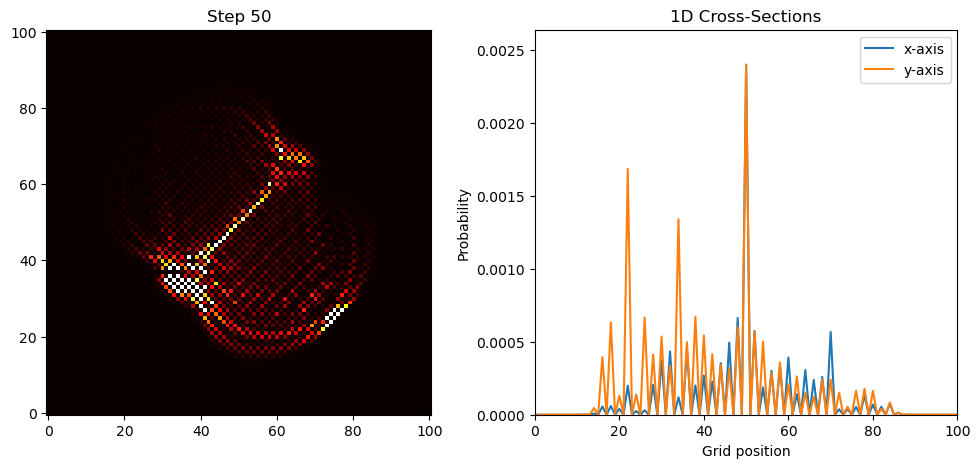

In [2]:
# Jupyter Notebook setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Parameters
num_steps = 50
grid_size = 2 * num_steps + 1
center = num_steps


# Choose coin type: "grover" or "hadamard"
coin_type = "hadamard"  # change to "grover" if desired

# Define coins
if coin_type == "grover":
    C = (1/2) * np.array([[-1, 1, 1, 1],
                          [ 1,-1, 1, 1],
                          [ 1, 1,-1, 1],
                          [ 1, 1, 1,-1]])
elif coin_type == "hadamard":
    C = (1/2) * np.array([[ 1,  1,  1,  1],
                          [ 1, -1,  1, -1],
                          [ 1,  1, -1, -1],
                          [ 1, -1, -1,  1]])
else:
    raise ValueError("Invalid coin type")

# Initialize state: 4 coin states × 2D grid
state = np.zeros((4, grid_size, grid_size), dtype=complex)
state[:, center, center] = [1, 0, 0, 0]  # asymmetric start to avoid center localization

# Shift operator
def shift(state):
    new_state = np.zeros_like(state)
    new_state[0, :-1, :] = state[0, 1:, :]   # up
    new_state[1, 1:, :] = state[1, :-1, :]   # down
    new_state[2, :, :-1] = state[2, :, 1:]   # left
    new_state[3, :, 1:] = state[3, :, :-1]   # right
    return new_state

# Apply coin locally at each grid point
def apply_coin(state, C):
    new_state = np.zeros_like(state)
    for i in range(grid_size):
        for j in range(grid_size):
            new_state[:, i, j] = C @ state[:, i, j]
    return new_state

# Store probabilities and cross-sections
probabilities_list = []
x_cross_sections = []
y_cross_sections = []

for _ in range(num_steps):
    state = apply_coin(state, C)
    state = shift(state)
    
    # Normalize globally to preserve total probability
    total_prob = np.sum(np.abs(state)**2)
    if total_prob > 0:
        state /= np.sqrt(total_prob)
    
    prob = np.sum(np.abs(state)**2, axis=0)
    probabilities_list.append(prob)
    x_cross_sections.append(prob[center, :])
    y_cross_sections.append(prob[:, center])
    
# Create animation
fig, (ax2d, ax1d) = plt.subplots(1, 2, figsize=(12,5))

# 2D probability heatmap
im = ax2d.imshow(probabilities_list[0], cmap='hot', origin='lower')
ax2d.set_title(f"2D Quantum Walk ({coin_type.capitalize()} Coin)")

# 1D cross-section lines
line_x, = ax1d.plot(x_cross_sections[0], label='x-axis')
line_y, = ax1d.plot(y_cross_sections[0], label='y-axis')
ax1d.set_xlim(0, grid_size-1)
ax1d.set_ylim(0, max(np.max(x_cross_sections[0]), np.max(y_cross_sections[0]))*1.1)
ax1d.set_title("1D Cross-Sections")
ax1d.set_xlabel("Grid position")
ax1d.set_ylabel("Probability")
ax1d.legend()

def update(frame):
    # Update 2D heatmap
    prob = probabilities_list[frame]
    im.set_data(prob / np.max(prob))  # normalize for visualization
    ax2d.set_title(f"Step {frame+1}")

    # Update 1D lines
    line_x.set_ydata(x_cross_sections[frame])
    line_y.set_ydata(y_cross_sections[frame])
    ax1d.set_ylim(0, max(np.max(x_cross_sections[frame]), np.max(y_cross_sections[frame]))*1.1)
    return [im, line_x, line_y]

ani = FuncAnimation(fig, update, frames=num_steps, interval=100, blit=True)
HTML(ani.to_jshtml())

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# ----------------------------
# User parameters
# ----------------------------
num_steps = 50
grid_size = num_steps + 1
center = int(num_steps/2)

coin_type = "grover"     # choose "grover", "hadamard", or "fourier"
decoherence_prob = 1  # choose 0.0, 0.25, 0.5, 0.75, 1.0

# ----------------------------
# Define coin
# ----------------------------
if coin_type == "grover":
    C = (1/2)*np.array([[-1,1,1,1],
                        [1,-1,1,1],
                        [1,1,-1,1],
                        [1,1,1,-1]])
    psi0 = [1/2,1/2,-1/2,-1/2] #from 2312.16076
elif coin_type == "hadamard":
    C = (1/2)*np.array([[1,1,1,1],
                        [1,-1,1,-1],
                        [1,1,-1,-1],
                        [1,-1,-1,1]])
    psi0 = [1/2,1j/2,-1j/2,1/2]#from 2312.16076
elif coin_type == "fourier":
    i = 1j
    C = (1/2)*np.array([[1,1,1,1],
                        [1,i,-1,-i],
                        [1,-1,1,-1],
                        [1,-i,-1,i]])
    psi0 = [1/2,(1-1j)/(2*np.sqrt(2)),1/2,-(1-1j)/(2*np.sqrt(2))]#from 2312.16076
else:
    raise ValueError("Invalid coin type")

# ----------------------------
# Shift and coin operations
# ----------------------------
def shift(state):
    new_state = np.zeros_like(state)
    new_state[0,:-1,:] = state[0,1:,:]   # up
    new_state[1,1:,:] = state[1,:-1,:]   # down
    new_state[2,:,:-1] = state[2,:,1:]   # left
    new_state[3,:,1:] = state[3,:,:-1]   # right
    return new_state

def apply_coin(state, C):
    new_state = np.zeros_like(state)
    for i in range(grid_size):
        for j in range(grid_size):
            new_state[:,i,j] = C @ state[:,i,j]
    return new_state

def apply_decoherence(state, p):
    """
    Apply decoherence on the coin with probability p.
    With probability p, the coin is replaced by an equal mixture of basis states.
    """
    new_state = state.copy()
    for i in range(grid_size):
        for j in range(grid_size):
            if np.random.rand() < p:
                total_prob = np.sum(np.abs(state[:, i, j])**2)
                # collapse to classical mixture (randomly select one coin direction)
                choice = np.random.choice(4)
                new_state[:, i, j] = 0
                new_state[choice, i, j] = np.sqrt(total_prob)
    return new_state

def normalize(state):
    total_prob = np.sum(np.abs(state)**2)
    return state / np.sqrt(total_prob)

# ----------------------------
# Initialize state and precompute probabilities
# ----------------------------
state = np.zeros((4,grid_size,grid_size), dtype=complex)
state[:,center,center] = psi0
state = normalize(state)

probabilities_list = []

for step in range(num_steps):
    state = apply_coin(state, C)
    state = shift(state)
    state = apply_decoherence(state, decoherence_prob)
    state = normalize(state)
    prob = np.sum(np.abs(state)**2, axis=0)
    probabilities_list.append(prob)

# ----------------------------
# Create animation
# ----------------------------
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(probabilities_list[0], cmap='hot', origin='lower')
ax.set_title(f"{coin_type.capitalize()} Coin, decoherence={decoherence_prob}")
ax.axis('off')

def update(frame):
    prob = probabilities_list[frame]
    im.set_data(prob/np.max(prob))
    ax.set_title(f"Step {frame+1} ({coin_type.capitalize()} Coin, decoherence={decoherence_prob})")
    return [im]

ani = FuncAnimation(fig, update, frames=num_steps, interval=200, blit=True)
plt.close(fig)

HTML(ani.to_jshtml())

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# ====== User choice ======
coin_type = "Hadamard"  # "Hadamard", "Grover", "Fourier"
decoherence_probs = [0.0, 0.5, 1.0]  # List of decoherence probabilities
num_steps = 50
grid_size = 2*num_steps + 1
center = num_steps
alpha = 0.5

if coin_type == "Hadamard":
    C = (1/np.sqrt(2)) * np.array([[1, 1],
                                       [1, -1]])
    psi0 = [alpha/np.sqrt(alpha**2+(1-alpha)**2),
                1j*(1-alpha)/np.sqrt(alpha**2+(1-alpha)**2)]
elif coin_type == "Grover":
    C = np.array([[0, 1],
                      [1, 0]])
    psi0 = [alpha/np.sqrt(alpha**2+(1-alpha)**2),
                (1-alpha)/np.sqrt(alpha**2+(1-alpha)**2)]
elif coin_type == "Fourier":
    omega = np.exp(1j * 2 * np.pi / 2)
    C = (1/np.sqrt(2)) * np.array([[1, 1],
                                       [1, omega]])
    psi0 = [alpha/np.sqrt(alpha**2+(1-alpha)**2),
                -1j*(1-alpha)/np.sqrt(alpha**2+(1-alpha)**2)]
else:
    raise ValueError("Invalid coin type")

# Functions
def shift_1d(state):
    new_state = np.zeros_like(state)
    new_state[0, :-1] = state[0, 1:]   # left
    new_state[1, 1:] = state[1, :-1]   # right
    return new_state

def apply_coin_1d(state, C):
    new_state = np.zeros_like(state)
    for i in range(grid_size):
        new_state[:, i] = C @ state[:, i]
    return new_state

def apply_decoherence_1d(state, p):
    """Collapse coin with probability p"""
    new_state = state.copy()
    for i in range(grid_size):
        if np.random.rand() < p:
            total_prob = np.sum(np.abs(state[:, i])**2)
            choice = np.random.choice(2)
            new_state[:, i] = 0
            new_state[choice, i] = np.sqrt(total_prob)
    return new_state

# Precompute walks for each decoherence probability
all_probabilities = []

np.random.seed(42)
for p in decoherence_probs:
    state = np.zeros((2, grid_size), dtype=complex)
    state[:, center] = psi0
    probs = []
    for _ in range(num_steps):
        state = apply_coin_1d(state, C)
        state = shift_1d(state)
        state = apply_decoherence_1d(state, p)
        # Normalize
        total_prob = np.sum(np.abs(state)**2)
        if total_prob > 0:
            state /= np.sqrt(total_prob)
        probs.append(np.sum(np.abs(state)**2, axis=0))
    # Smooth probabilities by averaging consecutive steps
    smoothed_probs = [0.5*(probs[t]+probs[t+1]) for t in range(num_steps-1)] + [probs[-1]]
    all_probabilities.append(smoothed_probs)

# Animation
fig, ax = plt.subplots(figsize=(10,5))
lines = [ax.plot(all_probabilities[i][0], label=f"p={decoherence_probs[i]}")[0] for i in range(len(decoherence_probs))]
ax.set_xlim(0, grid_size-1)
ax.set_ylim(0, 0.25)
ax.set_xlabel("Position")
ax.set_ylabel("Probability")
ax.set_title(f"1D Quantum Walk ({coin_type} Coin)")
ax.legend()

def update(frame):
    for i, line in enumerate(lines):
        line.set_ydata(all_probabilities[i][frame])
    ax.set_title(f"1D Quantum Walk ({coin_type} Coin) - Step {frame+1}/{num_steps}")
    return lines

ani = FuncAnimation(fig, update, frames=num_steps-1, interval=150, blit=True)
plt.close(fig)
HTML(ani.to_jshtml())